Dataset: Time Series daily Website Visitors

Quelle: https://www.kaggle.com/datasets/bobnau/daily-website-visitors

Inhalt: 5 Jahre tägliche Zeitreihendaten für verschiedene Messgrößen des Traffics auf einer Website für statistische Prognosen (statforecasting.com)

Variablen:
- tägliche Anzahl der Seitenaufrufe
- der einmaligen Besucher
- der Erstbesucher
- der wiederkehrenden Besucher

Zeitraum: 14.09.2014 - 19.08.2020

Ein Besuch ist definiert als ein Strom von Zugriffen auf eine oder mehrere Seiten der Website an einem bestimmten Tag durch ein und denselben Nutzer, der über die IP-Adresse identifiziert wird. 

Mehrere Personen mit einer gemeinsamen IP-Adresse (z. B. in einem Computerlabor) werden als ein einziger Nutzer betrachtet, so dass reale Nutzer bis zu einem gewissen Grad unterschätzt werden können. 

Ein Besuch wird als "einmalig" eingestuft, wenn es innerhalb der letzten 6 Stunden keinen Treffer von derselben IP-Adresse gegeben hat. 

Wiederkehrende Besucher werden durch Cookies identifiziert, wenn diese akzeptiert werden. 

Alle anderen werden als Erstbesucher eingestuft, so dass die Zahl der einmaligen Besucher per Definition die Summe der Zahlen der wiederkehrenden und der erstmaligen Besucher ist. 

Die Daten wurden über einen Verkehrsüberwachungsdienst namens StatCounter gesammelt.

In [32]:
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.tsa.seasonal as statseason

***1. Loading and Preprocessing***

In [19]:
# Load the data
data_path = "./daily-website-visitors.csv"
data = pd.read_csv(data_path)

data.head()

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,"2,146","1,582","1,430",152
1,2,Monday,2,9/15/2014,"3,621","2,528","2,297",231
2,3,Tuesday,3,9/16/2014,"3,698","2,630","2,352",278
3,4,Wednesday,4,9/17/2014,"3,667","2,614","2,327",287
4,5,Thursday,5,9/18/2014,"3,316","2,366","2,130",236


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Row                2167 non-null   int64 
 1   Day                2167 non-null   object
 2   Day.Of.Week        2167 non-null   int64 
 3   Date               2167 non-null   object
 4   Page.Loads         2167 non-null   object
 5   Unique.Visits      2167 non-null   object
 6   First.Time.Visits  2167 non-null   object
 7   Returning.Visits   2167 non-null   object
dtypes: int64(2), object(6)
memory usage: 135.6+ KB


In [21]:
# Function to remove commas
def remove_commas(x):
    return float(x.replace(',', ''))

In [22]:
# Apply the preprocessing functions

data['Date'] = pd.to_datetime(data['Date'])
data['Page.Loads'] = data['Page.Loads'].apply(lambda x : remove_commas(x))
data['Unique.Visits'] = data['Unique.Visits'].apply(lambda x : remove_commas(x))
data['First.Time.Visits'] = data['First.Time.Visits'].apply(lambda x : remove_commas(x))
data['Returning.Visits'] = data['Returning.Visits'].apply(lambda x : remove_commas(x))

In [23]:
data = data.drop(['Row','Day'], axis = 1)

In [24]:
col = ['Page.Loads', 'Unique.Visits', 'First.Time.Visits', 'Returning.Visits']

data[col] = data[col].replace(',', '', regex = True).astype('int64')

In [25]:
data['Date'] = data['Date'].astype('datetime64[ns]')
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.day
data.drop(columns = 'Date', inplace = True)

In [37]:
data["full_date"] = pd.to_datetime(data[['year', 'month', 'day']])

In [38]:
data.head()

,Day.Of.Week,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits,year,month,day,full_date
0,1,2146,1582,1430,152,2014,9,14,2014-09-14
1,2,3621,2528,2297,231,2014,9,15,2014-09-15
2,3,3698,2630,2352,278,2014,9,16,2014-09-16
3,4,3667,2614,2327,287,2014,9,17,2014-09-17
4,5,3316,2366,2130,236,2014,9,18,2014-09-18


In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Day.Of.Week        2167 non-null   int64         
 1   Page.Loads         2167 non-null   int64         
 2   Unique.Visits      2167 non-null   int64         
 3   First.Time.Visits  2167 non-null   int64         
 4   Returning.Visits   2167 non-null   int64         
 5   year               2167 non-null   int32         
 6   month              2167 non-null   int32         
 7   day                2167 non-null   int32         
 8   full_date          2167 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int32(3), int64(5)
memory usage: 127.1 KB


***EDA***

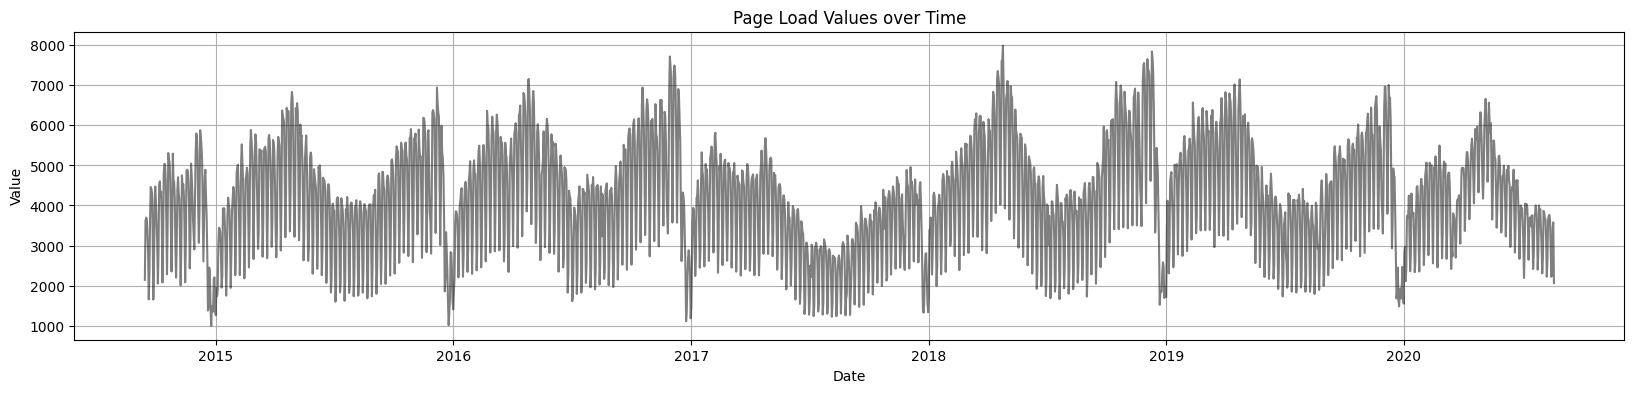

In [104]:
values = data['Page.Loads'].values
timestamps = data['full_date'].values

plt.figure(figsize=(20, 4))
plt.plot(timestamps, values, linestyle='-', color='black', alpha=0.5)

plt.title('Page Load Values over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)

plt.show()

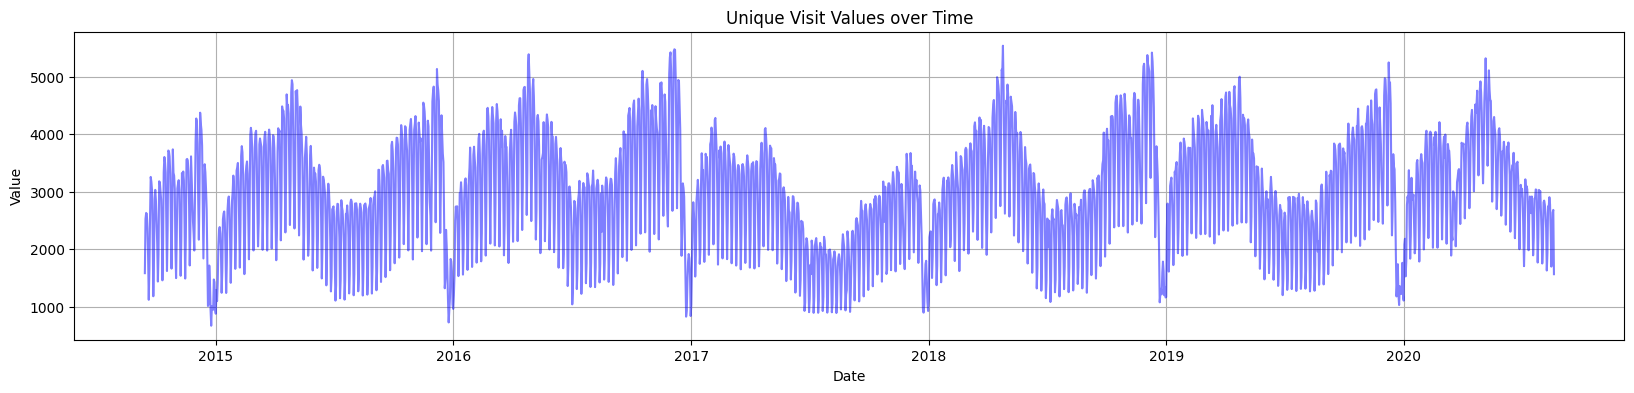

In [103]:
values = data['Unique.Visits'].values
timestamps = data['full_date'].values

plt.figure(figsize=(20, 4))
plt.plot(timestamps, values, linestyle='-', color='blue', alpha=0.5)

plt.title('Unique Visit Values over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)

plt.show()

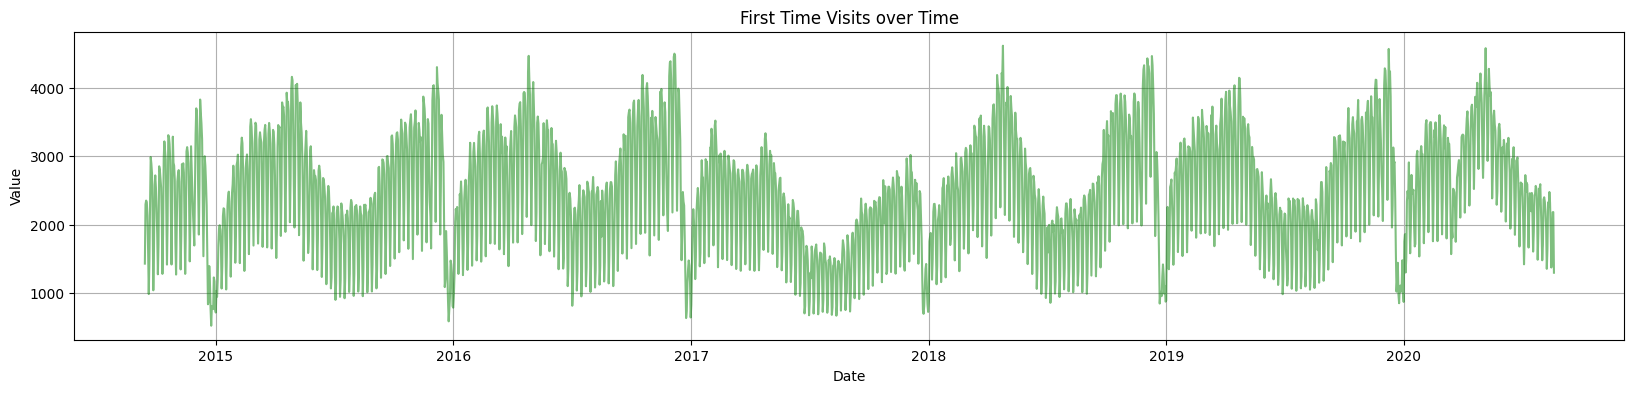

In [102]:
values = data['First.Time.Visits'].values
timestamps = data['full_date'].values

plt.figure(figsize=(20, 4))
plt.plot(timestamps, values, linestyle='-', color='green', alpha=0.5)

plt.title('First Time Visits over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)

plt.show()

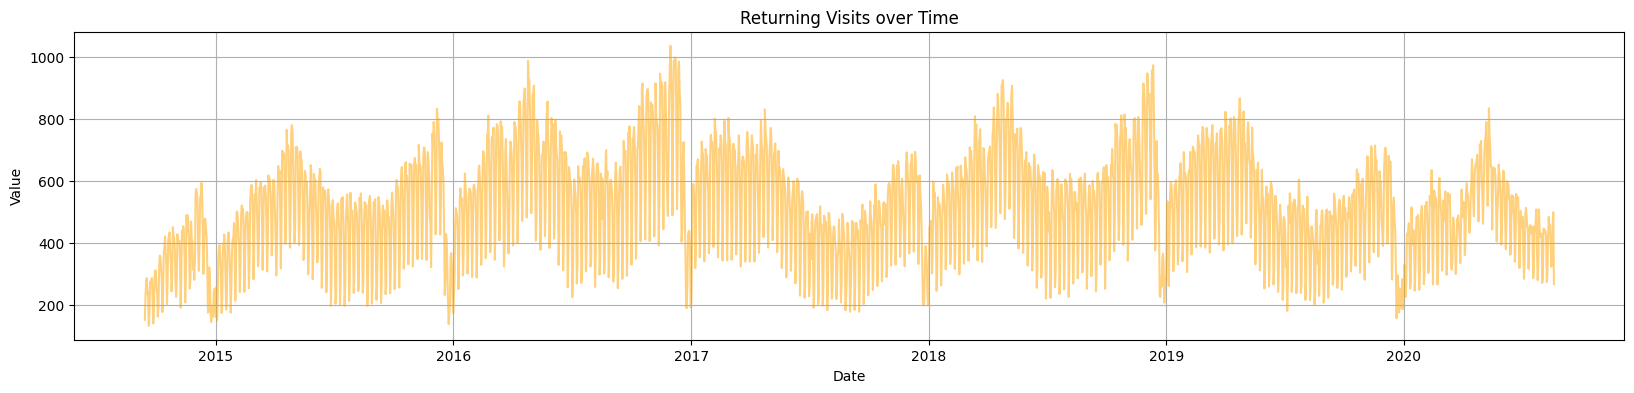

In [101]:
values = data['Returning.Visits'].values
timestamps = data['full_date'].values

plt.figure(figsize=(20, 4))
plt.plot(timestamps, values, linestyle='-', color='orange', alpha=0.5)

plt.title('Returning Visits over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)

plt.show()

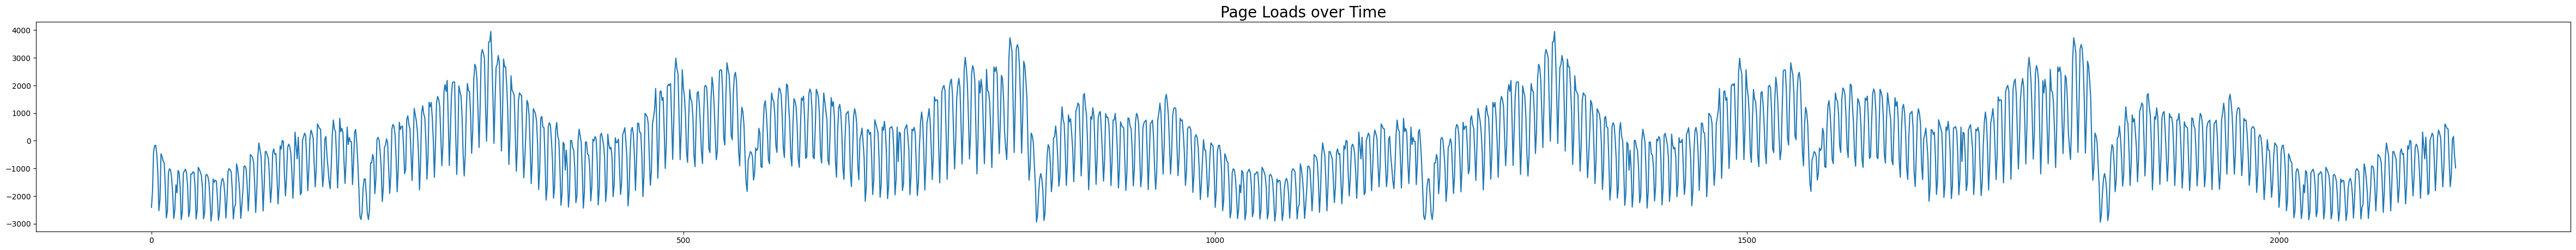

In [78]:
page_loads = data[['Page.Loads']] # can leave out date here because already sorted by date

plt.figure(figsize=(60,5))
plt.title('Page Loads over Time', fontsize=20)
season = statseason.seasonal_decompose(page_loads, model = "additive", period = 1000)
season.seasonal.plot()
plt.show()

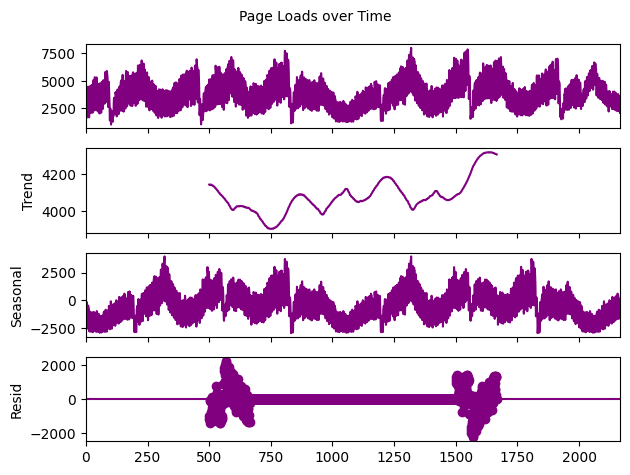

In [100]:
fig = season.plot()
fig.suptitle('Page Loads over Time', fontsize=10)
fig.tight_layout()

for ax in fig.axes:
    for line in ax.get_lines():
        line.set_color('purple') 

plt.show()

<Axes: >

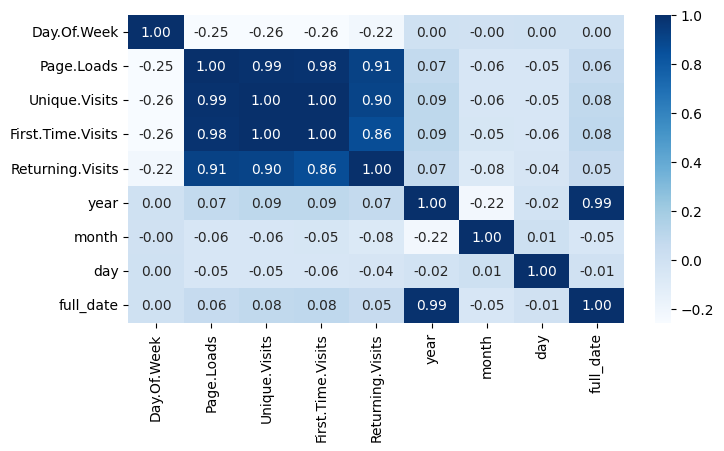

In [123]:
import seaborn as sns

corr = data.corr()
plt.figure(figsize=(8, 4))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap="Blues", annot=True, fmt=".2f")

***Test auf schwache Stationarität***

*Eine Zeitreihe ist schwach stationär, wenn ihr Mittelwert und ihre Varianz über die Zeit konstant sind und die Kovarianz zwischen zwei Zeitpunkten nur von der Zeitdifferenz und nicht von den tatsächlichen Zeitpunkten abhängt.*

In [145]:
# für die Tests Page Loads und full day 

X = pd.DataFrame(page_loads)
y = pd.DataFrame(timestamps)

In [151]:
dataframe = pd.concat([y, X], axis=1)
dataframe.columns = ['full_date', 'Page.Loads']

In [152]:
dataframe.head()

,full_date,Page.Loads
0,2014-09-14,2146
1,2014-09-15,3621
2,2014-09-16,3698
3,2014-09-17,3667
4,2014-09-18,3316


In [153]:
# Berechne die Varianz-Kovarianz-Matrix
cov_matrix = dataframe.cov()

print("Varianz-Kovarianz-Matrix:")
print(cov_matrix)

Varianz-Kovarianz-Matrix:
               full_date    Page.Loads
full_date   2.922567e+33  4.339116e+18
Page.Loads  4.339116e+18  1.825141e+06
